In [1]:
import pandas as pd
import data_cleanup as dc
import domain_comparison as doc
import data_exploration as de
import seaborn as sns
import matplotlib.pyplot as plt
import severity_score as ses
import numpy as np
from scipy.stats import gaussian_kde

### In this document the same operations as in all_dms are done. In this case the Amino acids, that cannot be reached with single mutations of the DNA are removed before.

Starting out with Generation of the new DF with only the single mutations

In [3]:
fpath = '../../DMS_data/P53_HUMAN_Giacomelli_NULL_Etoposide_2018.csv'

gia_null_eto =dc.norm(pd.read_csv(fpath))
dc.aufteilung_mut_pos(gia_null_eto)

p53_seq = ses.p53_codons_gia
translated_p53 = ses.clean_variation_matrix(ses.translate_codons_df(ses.generate_codon_variations(p53_seq)))

cleaned_p53 = ses.clean_variation_matrix(translated_p53)

df = gia_null_eto[gia_null_eto.apply(lambda row: (cleaned_p53.loc[row['position_mut']-1, 'Original'] == row['AS_old']) and (row['AS_new'] in cleaned_p53.loc[row['position_mut']-1, ['Variation 1', 'Variation 2', 'Variation 3', 'Variation 4', 'Variation 5', 'Variation 6', 'Variation 7', 'Variation 8', 'Variation 9']].values), axis=1)]

In [20]:
domains_regulatory = doc.domains_regulatory

def adjust_domain(regulatory: dict, name: str, frame: pd.DataFrame) -> dict:

    domain = dc.rmv_na(dc.df_transform(doc.slice_domain(frame, start= regulatory[name][0], end=regulatory[name][1])))
    domain_list = doc.slice_domain(frame, start= regulatory[name][0], end=regulatory[name][1])
    mean = domain.mean().rename('mean')
    res: dict = {'domain' : domain, 'domain_list': domain_list, 'mean': mean}
    return res


In [22]:
t1_domain = adjust_domain(domains_regulatory, name='t1_domain', frame=df)
t2_domain = adjust_domain(domains_regulatory, 't2_domain', frame=df)
pr_domain = adjust_domain(domains_regulatory, 'pr_domain', frame=df)
dna_domain = adjust_domain(domains_regulatory, 'dna_b_domain', frame=df)
tetra_domain = adjust_domain(domains_regulatory, 'tetra_domain', frame=df)
reg_domain = adjust_domain(domains_regulatory, 'reg_domain', frame=df)



## Mean values

In [24]:

t1_mean = t1_domain['mean']

t2_mean = t2_domain['mean']

pr_mean = pr_domain['mean']

dna_mean = dna_domain['mean']

tetra_mean = tetra_domain['mean']

reg_mean = reg_domain['mean']


## Distribution and Heatmaps
### Transactivation Domain 1

In [11]:
def distr_and_hmap(domain_reg: dict, domain_name: str) -> None:
    dms_scores = domain_reg['domain_list']['DMS_score']
    plt.hist(dms_scores, bins=50)
    plt.xlabel('DMS Score')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of DMS Scores in the {domain_name} Domain')
    plt.show()

    print(f'Mean: {dms_scores.mean()}')
    print(f'Median: {dms_scores.median()}')
    sns.heatmap(domain_reg['domain'])

    return None

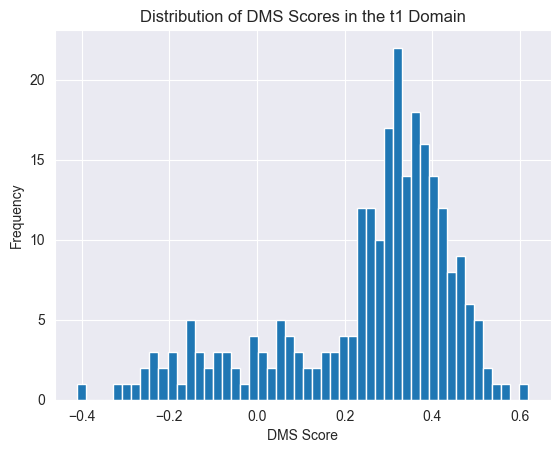

Mean: 0.25020519827662574
Median: 0.3124497496248526


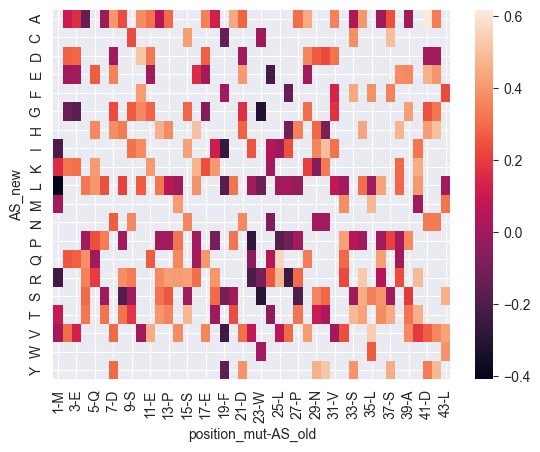

In [26]:
distr_and_hmap(t1_domain, 't1')

### Transactivation Domain 2

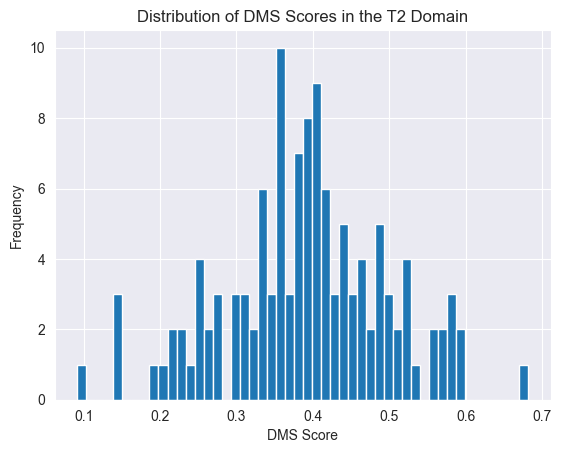

Mean: 0.3912060236058067
Median: 0.39395194195220495


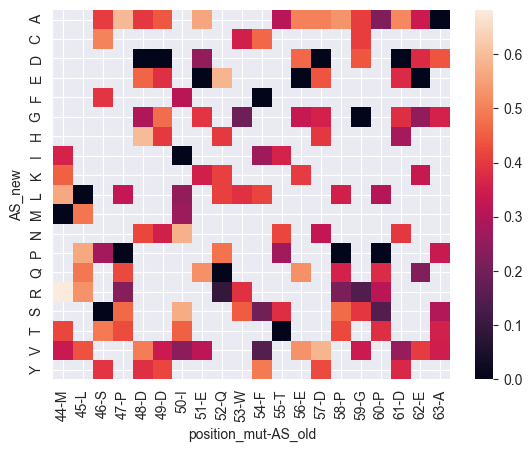

In [27]:
t2 = adjust_domain(domains_regulatory, 't2_domain', df)
distr_and_hmap(t2, 'T2')

### Proline-rich Region

In [ ]:
pr = adjust_domain(domains_regulatory, 'pr_domain', df)
distr_and_hmap(pr, 'Proline-rich Region')

### DNA Binding Domain

In [ ]:
dna_b_domain = adjust_domain(domains_regulatory, 'dna_b_domain', df)
distr_and_hmap(dna_b_domain, 'DNA Binding')

### Tetramerization Domain

In [ ]:
tetra = adjust_domain(domains_regulatory, 'tetra_domain', df)
distr_and_hmap(tetra, 'Tetramerisation')

### Regulatory Domain

In [ ]:
reg_domain = adjust_domain(domains_regulatory, 'reg_domain', df)
distr_and_hmap(reg_domain, 'Regulatory')

In [30]:
t1_domain['domain']

position_mut,1,2,3,4,5,6,7,8,9,10,...,34,35,36,37,38,39,40,41,42,43
AS_old,M,E,E,P,Q,S,D,P,S,V,...,P,L,P,S,Q,A,M,D,D,L
AS_new,,,,,,,,,,,,,,,,,,,,,
A,NaN,0.101538,0.162826,-0.145289,NaN,-0.008714,0.396086,0.235446,NaN,0.373992,...,0.394579,NaN,-0.003683,0.243956,NaN,0.000000,NaN,0.618377,0.338824,NaN
C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.236195,NaN,...,NaN,NaN,NaN,0.497523,NaN,NaN,NaN,NaN,NaN,NaN
D,NaN,0.273409,0.286890,NaN,NaN,NaN,0.000000,NaN,NaN,0.511602,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
E,NaN,0.000000,0.000000,NaN,0.265491,NaN,0.352874,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.376110,0.361747,NaN,0.465507,0.391559,NaN
F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.412928,...,NaN,0.385191,NaN,0.349753,NaN,NaN,NaN,NaN,NaN,0.229949
G,NaN,-0.133037,-0.162292,NaN,NaN,NaN,0.230833,NaN,0.263925,0.365132,...,NaN,NaN,NaN,NaN,NaN,0.417572,NaN,0.247535,0.325314,NaN
H,NaN,NaN,NaN,NaN,0.363887,NaN,0.375930,0.337151,NaN,NaN,...,0.437284,NaN,NaN,NaN,0.472161,NaN,NaN,0.416652,0.504019,NaN
I,-0.205230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.312450,0.370624,...,NaN,NaN,NaN,NaN,NaN,NaN,0.323120,NaN,NaN,NaN


## Comparing all DMS score distributions

In [32]:
def comp_dms_distr(regulatory: dict, frame) -> None:
    regions = [adjust_domain(regulatory, elem, frame)['domain_list']['DMS_score'] for elem in regulatory.keys()]
    dms_scores = np.concatenate(regions)

    fig, ax = plt.subplots(figsize=(10, 6))

    datasets = ['Transactivation domain 1', 'Transactivation domain 2', 'Proline rich region',
                'DNA binding domain', 'Tetramerization domain', 'Regulatory domain']
    for data, label in zip(regions, datasets):
        kde = gaussian_kde(data)
        x_vals = np.linspace(np.min(dms_scores), np.max(dms_scores), 1000)
        y_vals = kde(x_vals)

        ax.plot(x_vals, y_vals, linewidth=2, label=label)

    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.set_title('Different Domains with only Single Mutation DMS Scores')
    ax.legend()

    plt.show()
    return None

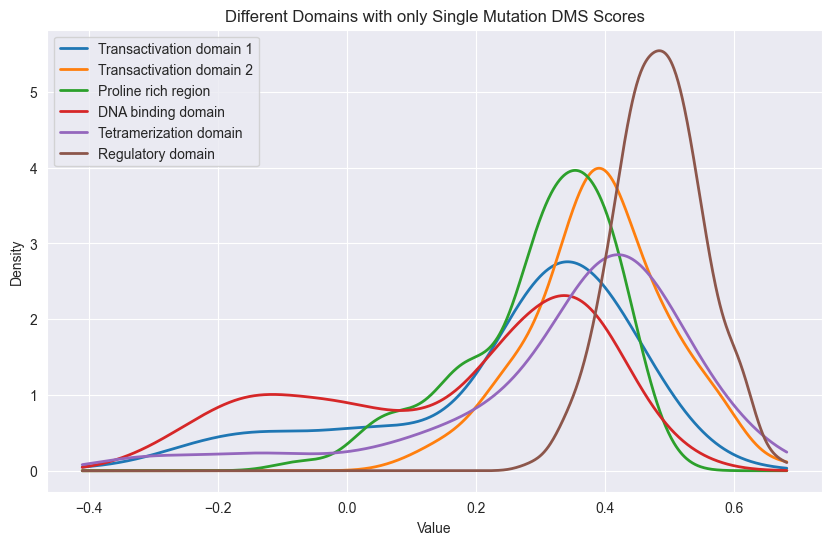

In [33]:
comp_dms_distr(domains_regulatory, df)

## Standard deviation


In [ ]:
t1_std = t1_mean.std()
t2_std = t2_mean.std()
pr_std = pr_mean.std()
dna_std = dna_mean.std()
tetra_std = tetra_mean.std()
reg_std = reg_mean.std()

std_combined = pd.DataFrame({
    't1_std': [t1_std],
    't2_std': [t2_std],
    'pr_std': [pr_std],
    'dna_std': [dna_std],
    'tetra_std': [tetra_std],
    'reg_std': [reg_std]
})

std_combined

## Mean value matrix

Creating a matrix showing the mean substitution DMS score for each aminoacid. For further information see the data_exploration folder.

<Axes: xlabel='AS_new', ylabel='AS_old'>

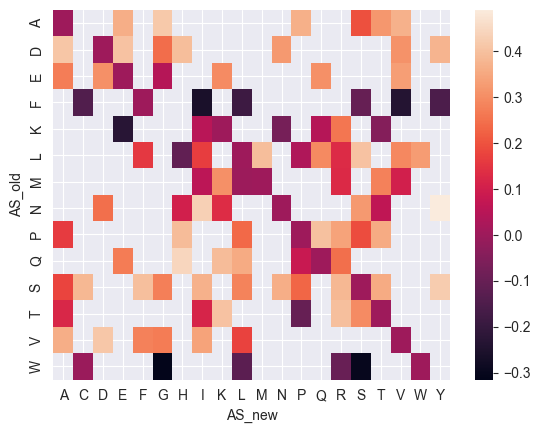

In [34]:
sns.heatmap(dc.rmv_na(de.mean_substitutions(t1_domain['domain_list'])))

<Axes: xlabel='AS_new', ylabel='AS_old'>

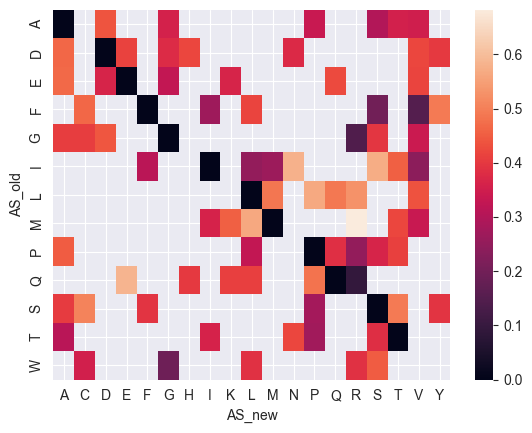

In [35]:
sns.heatmap(dc.rmv_na(de.mean_substitutions(t2_domain['domain_list'])))

<Axes: xlabel='AS_new', ylabel='AS_old'>

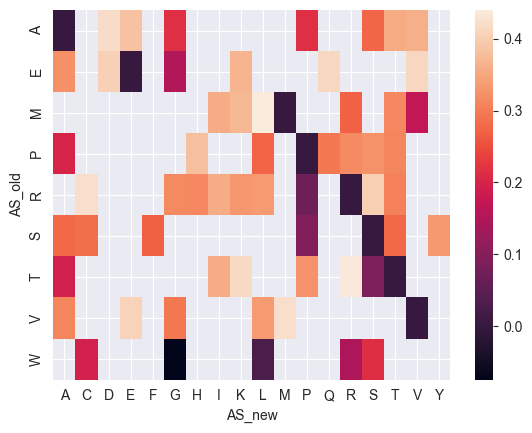

In [36]:
sns.heatmap(dc.rmv_na(de.mean_substitutions(pr_domain['domain_list'])))

<Axes: xlabel='AS_new', ylabel='AS_old'>

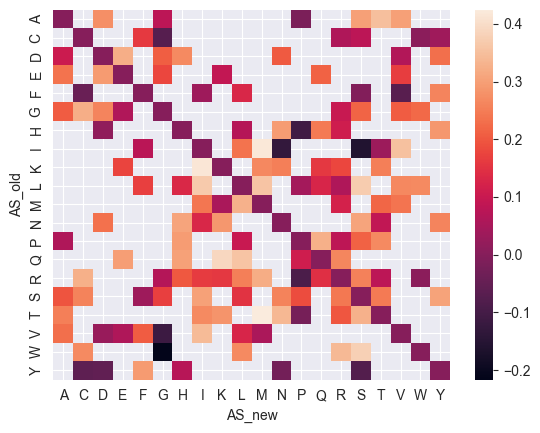

In [37]:
sns.heatmap(dc.rmv_na(de.mean_substitutions(dna_domain['domain_list'])))

In [ ]:
sns.heatmap(dc.rmv_na(de.mean_substitutions(tetra_domain['domain_list'])))

In [ ]:
sns.heatmap(dc.rmv_na(de.mean_substitutions(reg_domain['domain_list'])))

## Shapiro Wilk test

In [41]:
domains_regulatory.keys(1)

TypeError: dict.keys() takes no arguments (1 given)

In [46]:
def shapiro_wilk_test(regulatory: dict, frame) -> None:
    regions = [adjust_domain(regulatory, elem, frame)['domain_list']['DMS_score'] for elem in regulatory.keys()]
    reg_names = list(regulatory.keys())
    counter = 0
    for region in regions:
        print(reg_names[counter])
        counter += 1
        print(doc.test_normality(region), '\n')
    return None

In [47]:
shapiro_wilk_test(domains_regulatory, df)

t1_domain
{'statistic': 0.8876029849052429, 'p-value': 9.422345716159075e-13, 'is_normal': False} 

t2_domain
{'statistic': 0.9918556213378906, 'p-value': 0.6967766284942627, 'is_normal': True} 

pr_domain
{'statistic': 0.9207308292388916, 'p-value': 4.952158505489024e-08, 'is_normal': False} 

dna_b_domain
{'statistic': 0.9274617433547974, 'p-value': 6.247944345684872e-23, 'is_normal': False} 

tetra_domain
{'statistic': 0.8454704284667969, 'p-value': 1.0146552787424282e-13, 'is_normal': False} 

reg_domain
{'statistic': 0.9977548718452454, 'p-value': 0.9890923500061035, 'is_normal': True} 

